In [15]:


import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch import optim


from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.distributions.uniform import BoxUniform

from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform, MaskedPiecewiseRationalQuadraticAutoregressiveTransform

from nflows.transforms.permutations import ReversePermutation

## Define the target probability density

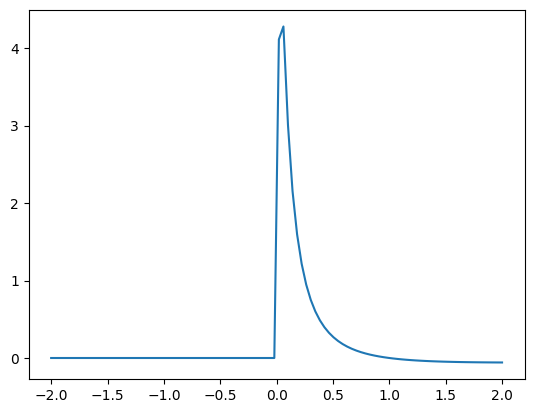

In [16]:
"""
def target_p(x, shape="triangle"):
    
    if shape == "normal":
        sigmasq = 3
        mean = 1
        return  (1.0/(np.sqrt(2*np.pi*sigmasq)))*torch.exp(-0.5*(x-mean)**2/sigmasq)
    
    elif shape == "triangle":
        return torch.where(torch.abs(x-3) < 1, -torch.abs(x-3)+1, 0)



x = torch.linspace(-5, 5, steps = 100)

plt.figure()
plt.plot(x, target_p(x))
plt.show()
"""

E0 = 500
cutoff = 0.5
R = 0.4

# def target_p(x):

#     mean = 0
#     std = 1

#     # Gaussian 
#     p = 1/np.sqrt(2 * np.pi  * std**2) * np.exp(- (x - mean)**2 / 2 / std**2)
#     return p



def Theta(x):
    return torch.where(x > 0, torch.ones_like(x), torch.zeros_like(x))

def alpha_s(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * torch.log(scale**2 / lambda_qcd**2))

def LO_angularity(lambda_, beta = 1):

    scale = E0 * torch.pow(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    return -torch.nan_to_num((2 * alpha_s_scale * C_F / (1 * np.pi * beta * R)) * torch.log(lambda_ ) / lambda_ * Theta(1 - lambda_) * Theta(lambda_))

def LL_angularity(lambda_, beta = 1):

    scale = E0 * torch.pow(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    return torch.nan_to_num(LO_angularity(lambda_, beta) * torch.exp(-1 * alpha_s_scale * C_F / (beta * R *  np.pi) * torch.pow(torch.log(lambda_), 2)) * Theta(1 - lambda_) * Theta(lambda_))


def alpha_s(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * torch.log(scale**2 / lambda_qcd**2))

target_p = LL_angularity

x = torch.linspace(-2, 2, steps = 100)

plt.figure()
plt.plot(x, target_p(x))
#plt.ylim(0, 6)
plt.show()


# Define the flow architecture

Standard flow training is $z = f(x)$ for physical variable $x$, latent variable $z$. In this case, the loss would be `loss = -flow.log_prob(inputs=x).mean()`, so we assume that we have physical samples $x$.

On our case, we know the target $p(x)$, and we don't have samples. We want `loss = calc_dkl(logp, logq)`, where the $q$ represents the flow action. 

With nflows, because we have a base distribution, we still *must* transform from $x$ to $z$. 



In [17]:
# Loss function
def calc_dkl(logp, logq, train_from_samples):

    if train_from_samples:
  
        return -(logp - logq).mean()# reverse KL, assuming samples from q
        
    else:
        return (-logp.exp()*(logq - logp)).mean()# reverse KL, assuming samples from q

In [18]:
base_dist = StandardNormal(shape=[1])

num_layers = 2
num_hidden_features = 64 # relaed to network width
num_blocks = 8 # related to network depth
num_bins = 6 # essentially how many piecewise splines we want
transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=1))
    # only use MAAT if the distribution has nonzero support everywhere
    #transforms.append(MaskedAffineAutoregressiveTransform(features=1, hidden_features = 128))
    transforms.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(features = 1, 
                                       hidden_features = num_hidden_features, num_blocks = num_blocks, tail_bound = 5, 
                                                   num_bins = num_bins, tails = "linear"))

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters(), lr = 0.001)


In [19]:
from tqdm import tqdm

num_epochs = 2000
train_losses = []

batch_size = 256

train_from_samples = False

for i in tqdm(range(num_epochs)):
    
    optimizer.zero_grad()
    
    if train_from_samples:
        

        # SAMPLE FROM THE PRIOR z
        z_samples = flow._distribution.sample(batch_size) 
        
        # APPLY FLOW TO PRIOR
        log_p_of_z_flow = flow._distribution.log_prob(z_samples)

        x_samples, log_dx_dz = flow._transform(z_samples)
        
        log_p_of_x_flow = log_p_of_z_flow - log_dx_dz
        
        
        

    else:
        
        # PULL VALUES OF x
        x_samples = torch.linspace(-2, 6, steps = batch_size).reshape(-1,1)
        x_samples = torch.rand(batch_size, 1) * 6 - 3
    
        # APPLY INVERSE FLOW TO x
        z_samples, log_dz_dx = flow._transform.inverse(x_samples)
        log_p_of_z_flow = flow._distribution.log_prob(z_samples) 
        log_p_of_x_flow = log_p_of_z_flow + log_dz_dx

    
        
    logp = torch.log(target_p(x_samples)).reshape(-1)
    
    #for i in range(10):
        #print(x_samples[i], target_p(x_samples)[i], logp[i])
    
    loss = calc_dkl(logp, log_p_of_x_flow, train_from_samples)
    
    loss.backward()
    optimizer.step()
        
    train_losses.append(loss.detach().cpu().numpy())
    

    

  0%|          | 1/2000 [00:00<22:12,  1.50it/s]


AssertionError: 

/tmp/ipykernel_112032/348178517.py:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


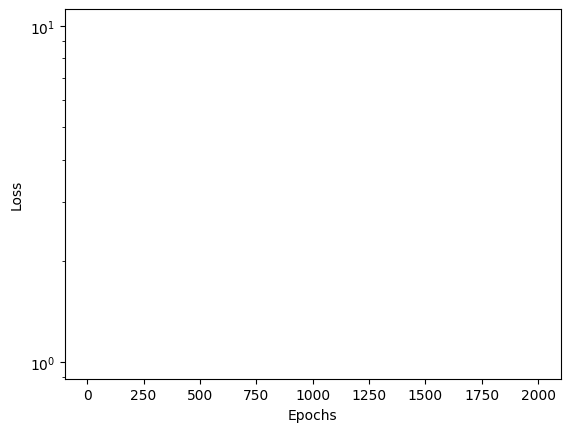

In [13]:
plt.figure()
plt.plot(np.nan_to_num(train_losses))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()



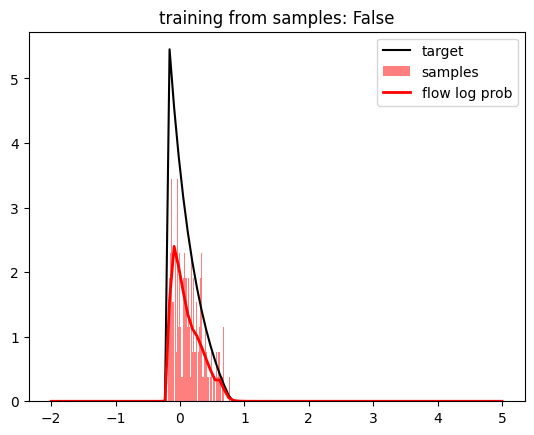

In [14]:




plt.figure()

# plot target
x_test = torch.linspace(-2, 5,steps = 100).reshape(-1,1)
plt.plot(x_test, target_p(x_test), label = "target", color = "black")


# plot flow samples
z_samples = flow._distribution.sample(batch_size) 
x, _ = flow._transform(z_samples)  
plt.hist(x.detach().cpu().numpy().reshape(-1,), bins = 100, density = True, label = "samples", color = "red", alpha = 0.5)

# plot flow log prob
z, dz_dx = flow._transform.inverse(x_test)  
px = (flow._distribution.log_prob(z) + dz_dx).exp()
plt.plot(x_test.detach().cpu().numpy(), px.detach().cpu().numpy(), label = "flow log prob", color = "red", lw = 2)

plt.legend()
plt.title("training from samples: "+str(train_from_samples))

#plt.xlim(-1, 2)
plt.show()
